## Importación de las librerías necesarias 

In [3]:
import numpy as np
import pandas as pd
import ydata_profiling as ydp
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from nltk.stem import PorterStemmer

* Observación: el sistema de recomendación de películas basado en filtro de contenido que se desarrollará en la etapa de ML se basa únicamente en el DataFrame df_platform que fue visto en la etapa de Transformaciones, el cual contiene información relevante sobre las características de cada película, como título, director, actores, país, género, sinopsis y puntaje promedio, entre otros. No se utilizará el DataFrame df_score, ya que el enfoque se centra en encontrar similitudes entre películas y no en los gustos de los usuarios. La inclusión del df_score en el modelo convertiría el enfoque en un filtro colaborativo, lo cual no es parte de los requerimientos establecidos en las consignas. Por último, el EDA y ETL para la etapa de Machine Learning se realizarán paralelamente.

## EDA y ETL (ML)

#### Carga de datos

In [4]:
df_movie=pd.read_csv(r"https://raw.githubusercontent.com/JersonGB22/ProyectoIndividualN1/main/Datasets/platform_transformation.csv")
df_movie.head(3)

,id,type,title,director,cast,country,date_added,release_year,rating,listed_in,description,duration_int,duration_type,score
0,as1,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,2021-03-30,2014,g,"comedy, drama",a small fishing village must procure a local d...,113.0,min,3.47
1,as2,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,2021-03-30,2018,13+,"drama, international",a metro family decides to fight a cyber crimin...,110.0,min,3.55
2,as3,movie,secrets of deception,josh webber,"tom sizemore, lorenzo lamas, robert lasardo, r...",united states,2021-03-30,2017,g,"action, drama, suspense",after a man discovers his wife is cheating on ...,74.0,min,3.50


In [5]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             22998 non-null  object 
 1   type           22998 non-null  object 
 2   title          22998 non-null  object 
 3   director       14739 non-null  object 
 4   cast           17677 non-null  object 
 5   country        11499 non-null  object 
 6   date_added     13444 non-null  object 
 7   release_year   22998 non-null  int64  
 8   rating         22998 non-null  object 
 9   listed_in      22998 non-null  object 
 10  description    22994 non-null  object 
 11  duration_int   22811 non-null  float64
 12  duration_type  22811 non-null  object 
 13  score          22998 non-null  float64
dtypes: float64(2), int64(1), object(11)
memory usage: 2.5+ MB


#### Reporte EDA en ydata-profiling

In [5]:
report=ydp.ProfileReport(df_movie,title="Reporte EDA: Plataformas de Streaming")
report.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
report.to_file("ReportEDA_PlatformStreaming.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

[Enlace del Reporte HTML alojado en Drive to Web](https://huknt1mctoiumyo41mctaq.on.drv.tw/ArchivosHTML/ReportEDA_PlatformStreaming.html)

Conclusiones importantes del reporte: 
* Este EDA se realiza antes de preprocesar los datos para la etapa de ML.
* Hay ocho variables con una alta cardinalidad, lo que significa que tienen una gran cantidad de valores diferentes. Esta característica dificulta la visualización de los datos y la identificación de patrones o relaciones con otras variables. Debido a esto, las gráficas de estas variables se limita principalmente al reporte generado por  ydata-profiling (antes conocido como pandas-profiling).
* Según el análisis del heatmap, se observa una correlación positiva significativa (superior a 0.5) entre las variables 'duration_int', 'duration_type' y 'type'. Esta correlación indica que hay una relación fuerte entre estas variables y que es probable que su comportamiento esté relacionado de alguna manera.

### Transformaciones

#### Eliminación de columnas innecesarias

* Se eliminará la columna `date_added` debido a que la fecha de adición puede ser redundante con otras características, como el año de lanzamiento de la película (release_year). Asimismo tiene muchos valores nulos (9554) y sería muy complejo de imputar estos valores por tratarse de fechas exactas.
* Columnas `release_year`, `duration_int` y `score`: para un sistema de recomendación con filtro de contenido que utiliza técnicas de lematización y count vectorizer, las columnas de "release_year", "duration_int" y "score" pueden ser eliminadas debido a que estas variables numéricas no aportan información relevante para la descripción del contenido textual de las películas. La información de la fecha de lanzamiento y duración de la película son útiles para la recomendación basada en popularidad o duración, pero no tienen un impacto significativo en la representación de los términos relevantes en la descripción de la película. Asimismo, el puntaje otorgado por los usuarios es subjetivo y no necesariamente está relacionado con los términos clave que describen el contenido de la película. En consecuencia, la eliminación de estas columnas puede mejorar la calidad de la representación del texto y por ende la precisión de las recomendaciones. No obstante, se mantendrán para su respectivo EDA y luego se eliminarán.

In [6]:
# Cantidad de nulos de la columna date_added
df_movie[df_movie.date_added.isnull()].shape[0]

9554

In [7]:
df_movie=df_movie.drop(columns=["date_added"])
df_movie.head(2)

,id,type,title,director,cast,country,release_year,rating,listed_in,description,duration_int,duration_type,score
0,as1,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,2014,g,"comedy, drama",a small fishing village must procure a local d...,113.0,min,3.47
1,as2,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,2018,13+,"drama, international",a metro family decides to fight a cyber crimin...,110.0,min,3.55


#### Tratamiento de valores faltantes

* Columna duration_type: se imputarán sus valores faltantes en base a la fuerte correlación positiva que tiene con la columna type, aprovechando que esta no tiene nulos y que se cumple la siguiente relación: ``[type=movie : duration_type=min; type=tv show duration_type=season]``

In [8]:
df_movie["duration_type"]=df_movie.apply(lambda x: ("min" if x.type=="movie" else "season") if pd.isna(x.duration_type) 
                                        else x.duration_type,axis=1)

* Columna duration_int: de manera análoga al caso anterior, inputaremos el campo "duration_int" utilizando la media de la duración de todas las películas en la misma categoría, es decir, para las películas de tipo "movie" (min) y para las series de tipo "tv show" (season).

In [9]:
df_movie.duration_int.fillna(df_movie.type.map(pd.Series({"movie":df_movie[df_movie.type=="movie"].duration_int.mean().round(),
                                                          "tv show":df_movie[df_movie.type=="tv show"].duration_int.mean().round()})),
                                                          inplace=True)

* Columnas director, cast, country, description: se inputarán con cadenas vacías ("") en columnas de texto para sistemas de recomendación basados en contenido ya que esto permite al modelo considerar la ausencia de información como una característica adicional. Además, las cadenas vacías son manejadas naturalmente por modelos de procesamiento de lenguaje natural como CountVectorizer, como veremos más adelante, mientras que "unknown" puede ser interpretado como una categoría real y confundir al modelo, llevando a resultados menos precisos.

In [10]:
df_movie.fillna({"director":"","cast":"","country":"","description":""},inplace=True)

In [11]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             22998 non-null  object 
 1   type           22998 non-null  object 
 2   title          22998 non-null  object 
 3   director       22998 non-null  object 
 4   cast           22998 non-null  object 
 5   country        22998 non-null  object 
 6   release_year   22998 non-null  int64  
 7   rating         22998 non-null  object 
 8   listed_in      22998 non-null  object 
 9   description    22998 non-null  object 
 10  duration_int   22998 non-null  float64
 11  duration_type  22998 non-null  object 
 12  score          22998 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.3+ MB


#### EDA: Variables Numéricas

##### Gráfico de Cajas

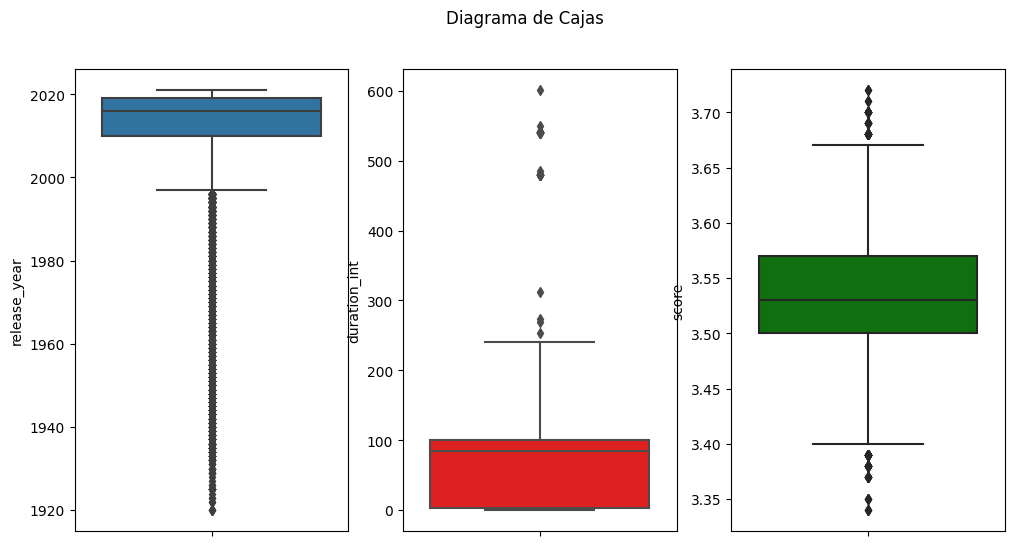

In [121]:
fig,ax=plt.subplots(1,3,figsize=(12,6))
fig.suptitle("Diagrama de Cajas")
sns.boxplot(y="release_year",data=df_movie,ax=ax[0])
sns.boxplot(y="duration_int",data=df_movie,ax=ax[1],color="red")
sns.boxplot(y="score",data=df_movie,ax=ax[2],color="green");

In [12]:
# Visualizando posibles errores en 'duration_int' (min)
df_movie[df_movie.duration_int<=0]

,id,type,title,director,cast,country,release_year,rating,listed_in,description,duration_int,duration_type,score
788,as789,movie,testing title - parichey is using this title,tester,test1,,2020,g,action,test movie for upload,0.0,min,3.52
1381,as1382,movie,paradise canyon - digitally remastered,carl pierson,"john wayne, marion burns, earle hodgins, yakim...",,1935,7+,"action, adventure",an undercover agent for the government is sent...,0.0,min,3.56
1590,as1591,movie,movie_project_un_test_uhd,test director,"test actor 1, test actor 2",,2019,g,comedy,movie_project_un_test_uhd short,0.0,min,3.53
4704,as4705,movie,asin_tombstone_test_target,test director,"test actor 1, test actor 2",,2019,g,comedy,asin_tombstone_test_target short,0.0,min,3.57
5162,as5163,movie,asin_tombstone_test_target_04,test director,"test actor 1, test actor 2",,2019,g,comedy,asin_tombstone_test_target_04 short,0.0,min,3.63
5191,as5192,movie,asintombstonetest-target,test director,"test actor 1, test actor 2",,2019,g,comedy,asintombstonetest-target short,0.0,min,3.52
5701,as5702,movie,primevideoqatestmovie16 us,test director us,"test actor1 us, test actor2",,2015,g,"action, drama",primevideoqatestmovie16 us title summary goes ...,0.0,min,3.54
6219,as6220,movie,primevideoqamovie11 us,test director us,"test actor1 us, test actor2",,2015,g,"action, drama",primevideoqamovie11 us title summary goes here...,0.0,min,3.56
8575,as8576,movie,projectununapprovedmovietarget,test director,"test actor 1, test actor 2",,2019,g,comedy,projectununapprovedmovietarget short,0.0,min,3.62
8834,as8835,movie,molly and me,lewis seiler,"gracie fields, roddy mcdowall, monty woolley, ...",,1945,pg,"arts, entertainment, and culture, comedy","molly (fields), a poor struggling actress, dec...",0.0,min,3.56


Conclusiones:
* En la variable 'release_year', se pueden observar una gran cantidad de valores atípicos inferiores debido a la gran cantidad de contenido audiovisual de los últimos años en las plataformas de streaming. Esto puede deberse a que se han incluido películas con una fecha de estreno anterior a la plataforma de streaming, o bien a que se han incorporado películas más antiguas que siguen siendo relevantes para el público actual.
* Asimismo, en la variable 'duration_int' se han detectado valores extremadamente bajos, incluso iguales a cero, lo que podría deberse a errores en la recolección o registro de los datos. Pero también podría tratarse de cortometrajes muy breves de menos de un minuto (segundos) por lo que se consideró cero minutos. En consecuencia, no se elimnarán estos datos.
* En cuanto a los valores atípicos superiores, se han detectado en las variables 'score' y 'duration_int'. En esta última variable, se han encontrado valores que se alejan significativamente del resto de los datos, incluso más allá del bigote superior. Estos valores podrían deberse a errores en la recolección o registro de los datos, o bien a películas que tienen características muy distintivas en cuanto a su duración. En el caso de la variable 'score', los valores atípicos superiores pueden deberse a películas que han sido extremadamente populares o bien a películas que han sido valoradas positivamente por un número reducido de usuarios, lo que genera una gran variabilidad en la puntuación.

##### Histogramas

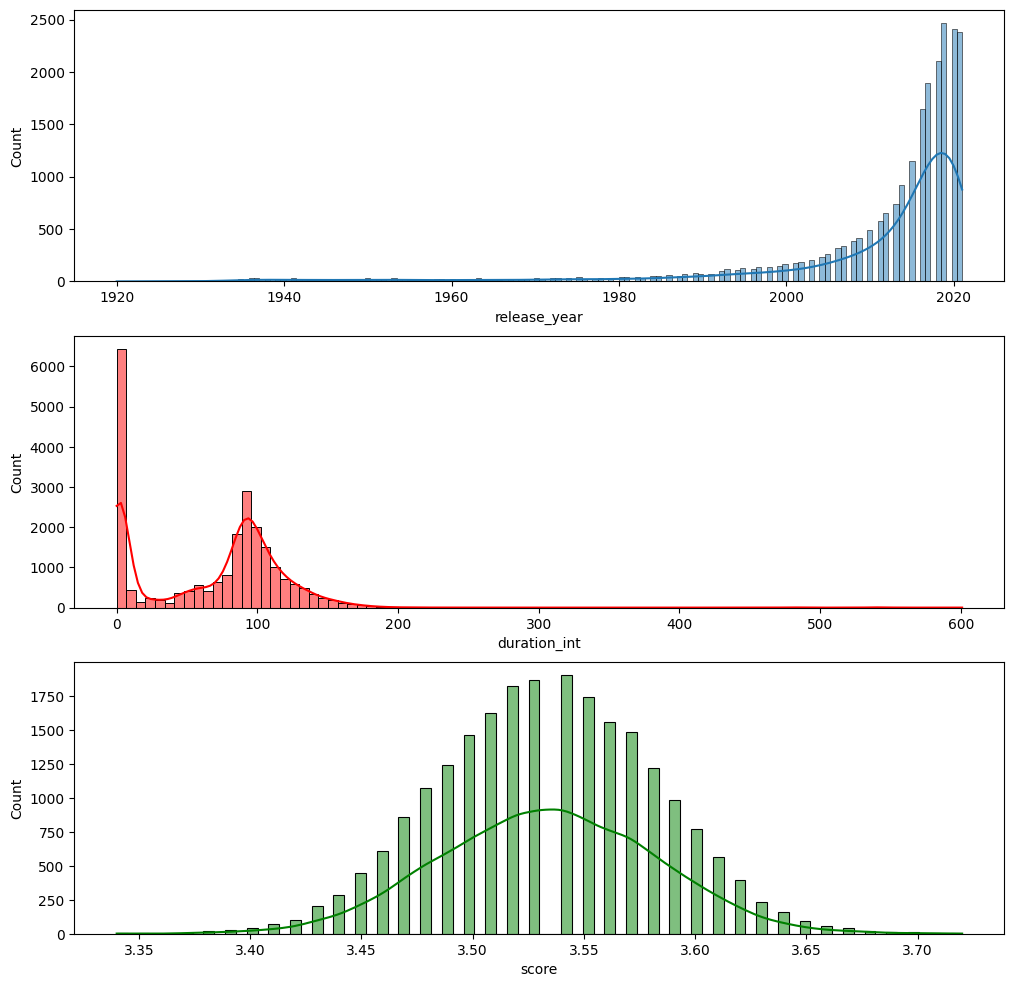

In [123]:
fig,ax=plt.subplots(3,1,figsize=(12,12))
sns.histplot(data=df_movie,x="release_year",kde=True,ax=ax[0])
sns.histplot(data=df_movie,x="duration_int",kde=True,ax=ax[1],color="red")
sns.histplot(data=df_movie,x="score",kde=True,ax=ax[2],color="green");

* Se puede observar que el histograma de la variable 'release_year' es sesgado hacia la izquierda debido a dos factores principales: en primer lugar, la presencia de outliers inferiores, que son valores extremadamente bajos en relación con la media de la distribución y que arrastran el histograma hacia ese lado. En segundo lugar, se encuentra una gran cantidad de películas que se añadieron a la plataforma en torno al año 2019, lo que genera una acumulación de observaciones en ese punto y causa un desequilibrio en la distribución de frecuencias.
* El histograma de la variable 'duration_int' muestra una distribución multimodal, es decir, con varios picos o modas que corresponden a diferentes intervalos de duración de las películas. En este caso, los picos principales se encuentran alrededor de los 1 y 90 minutos de duración. Además, se aprecia una asimetría hacia la derecha, lo que indica la presencia de outliers superiores y valores atípicos muy alejados de la media de la distribución, que influyen en la forma de la distribución y afectan a su interpretación.
* Finalmente, el histograma de la variable 'score' muestra una distribución simétrica con un pico máximo aproximadamente en 3.54. Esto indica que la mayoría de las películas tienen una puntuación cercana a ese valor, y que las frecuencias disminuyen a medida que nos alejamos de él hacia ambos lados.

##### Pairplot

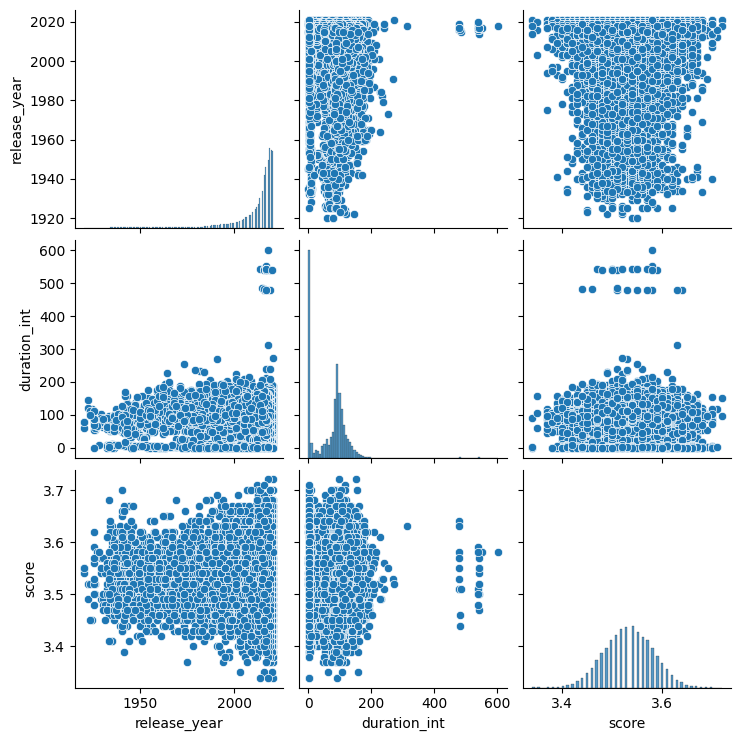

In [124]:
sns.pairplot(data=df_movie);

* Con este gráfico podemos visualizar mejor los outliers, los puntos que se alejan de las agrupaciones de puntos. Estos puntos suelen ubicarse lejos de las agrupaciones de puntos y pueden ser indicativos de anomalías o errores en los datos

#### EDA: Variables categóricas

##### Countplot

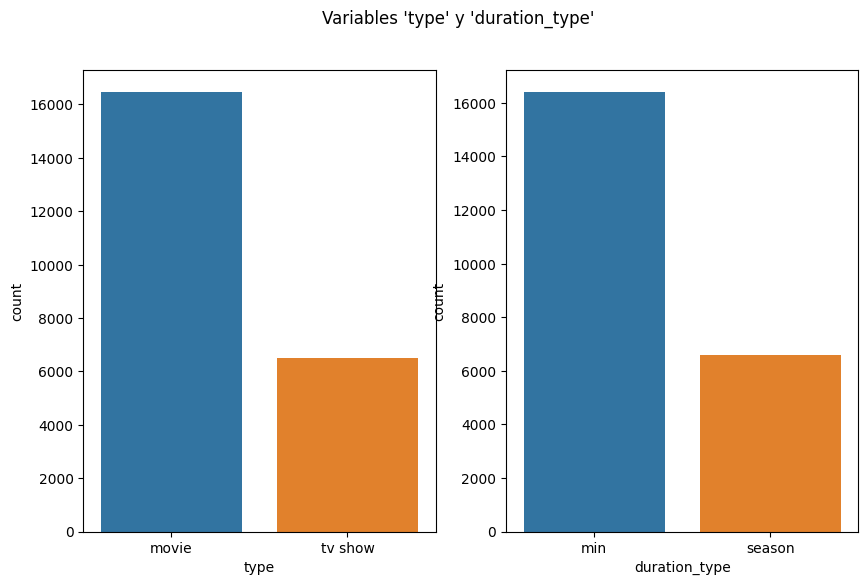

In [125]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
fig.suptitle("Variables 'type' y 'duration_type'")
sns.countplot(x="type",data=df_movie,ax=ax[0])
sns.countplot(x="duration_type",data=df_movie,ax=ax[1]);

In [13]:
print("Porcentaje 'movie': ",((df_movie[df_movie.type=="movie"].type.count())/df_movie.shape[0])*100,"%")
print("Porcentaje 'min': ",((df_movie[df_movie.duration_type=="min"].duration_type.count())/df_movie.shape[0])*100,"%")

Porcentaje 'movie':  71.66275328289416 %
Porcentaje 'min':  71.39316462301069 %


* Las variables 'type' y 'duration_type' presentan un desequilibrio importante en el que 'movie' y 'min' representan más del 71% de los registros. Esta similitud del porcentaje se debe a la alta correlación positiva que existe entre estas variables.

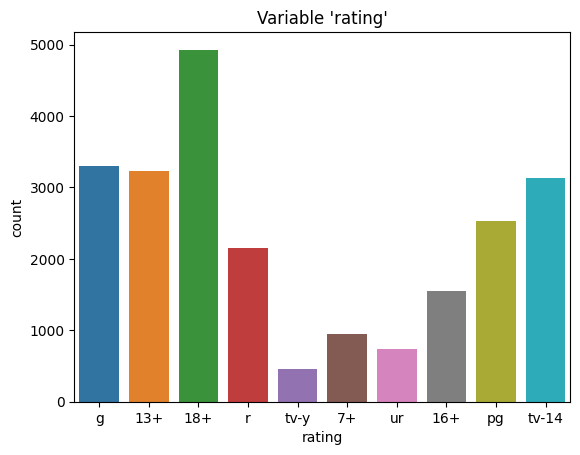

In [127]:
sns.countplot(x="rating",data=df_movie)
plt.title("Variable 'rating'");

Se puede observar una marcada diferencia en la cantidad de contenido recomendado para diferentes grupos de edad. Específicamente, se evidencia que la mayor cantidad de registros de contenido se encuentra en la categoría para mayores de 18 años (18+), mientras que el contenido apto para niños de todas las edades (tv-y) es significativamente menor en comparación. Esta diferencia en la cantidad de contenido disponible puede deberse a diversas razones, como la demanda de los usuarios, las políticas de las plataformas o la disponibilidad de material para cada categoría.

### Preprocesamiento de Texto

Este proceso permite extraer las características más relevantes de cada texto y crear un espacio vectorial que facilita la comparación y recomendación de textos similares. Un preprocesamiento adecuado es clave para lograr un sistema de recomendación preciso y eficiente.

In [13]:
# Eliminación de las columnas numéricas
df_movie.drop(columns=["release_year","duration_int","score"],inplace=True)

* Eliminación de los signos de puntuación de la columna `description`

Antes de realizar la lematización de la columna "description" para el sistema de recomendación de películas con filtro de contenido, es recomendable eliminar los signos de puntuación, así como también eliminar las palabras comunes como artículos, conjunciones y preposiciones, ya que no aportan información relevante al contenido de la película.

In [14]:
# Implementando una función que realize este trabajo
def preprocess_text(text):
    #Eliminación de los signos de puntuación utilizando con la librería regex
    text=re.sub(r"[^\w\s]","",text)
    #Eliminación de artículos, conjunciones y preposiciones.
    li_acp=["the","and","of","in","a","an","is","to","at","that","with","for","on","by","as","it","this","from","but","not"]
    text=text.split()
    text=[word for word in text if word not in li_acp]
    return text

In [15]:
df_movie["description"]=df_movie.description.apply(preprocess_text)
df_movie.head(3)

,id,type,title,director,cast,country,rating,listed_in,description,duration_type
0,as1,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,g,"comedy, drama","[small, fishing, village, must, procure, local...",min
1,as2,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,13+,"drama, international","[metro, family, decides, fight, cyber, crimina...",min
2,as3,movie,secrets of deception,josh webber,"tom sizemore, lorenzo lamas, robert lasardo, r...",united states,g,"action, drama, suspense","[after, man, discovers, his, wife, cheating, h...",min


* Conversión de las columnas de strings a listas

In [16]:
df_movie["type"]=df_movie.type.apply(lambda x: ["movie"] if x=="movie" else ["tv show"])
df_movie["director"]=df_movie.director.str.split(", ")
df_movie["cast"]=df_movie.cast.str.split(", ")
df_movie["country"]=df_movie.country.str.split(", ")
df_movie["rating"]=df_movie.rating.str.split()
df_movie["listed_in"]=df_movie.listed_in.str.split(", ")
# Reemplazo de "min" por "minute" para mayor consistencia  del lenguaje y evitar ambigüedades
df_movie["duration_type"]=df_movie.duration_type.replace("min","minute")
df_movie["duration_type"]=df_movie.duration_type.str.split()
# Observando como quedó nuestro data frame
df_movie

,id,type,title,director,cast,country,rating,listed_in,description,duration_type
0,as1,[movie],the grand seduction,[don mckellar],"[brendan gleeson, taylor kitsch, gordon pinsent]",[canada],[g],"[comedy, drama]","[small, fishing, village, must, procure, local...",[minute]
1,as2,[movie],take care good night,[girish joshi],"[mahesh manjrekar, abhay mahajan, sachin khede...",[india],[13+],"[drama, international]","[metro, family, decides, fight, cyber, crimina...",[minute]
2,as3,[movie],secrets of deception,[josh webber],"[tom sizemore, lorenzo lamas, robert lasardo, ...",[united states],[g],"[action, drama, suspense]","[after, man, discovers, his, wife, cheating, h...",[minute]
3,as4,[movie],pink: staying true,[sonia anderson],"[interviews with: pink, adele, beyoncé, britne...",[united states],[g],[documentary],"[pink, breaks, mold, once, again, bringing, he...",[minute]
4,as5,[movie],monster maker,[giles foster],"[harry dean stanton, kieran o'brien, george co...",[united kingdom],[g],"[drama, fantasy]","[teenage, matt, banting, wants, work, famous, ...",[minute]
...,...,...,...,...,...,...,...,...,...,...
22993,ns8803,[movie],zodiac,[david fincher],"[mark ruffalo, jake gyllenhaal, robert downey ...",[united states],[r],"[cult movies, dramas, thrillers]","[political, cartoonist, crime, reporter, pair,...",[minute]
22994,ns8804,[tv show],zombie dumb,[],[],[],[7+],"[kids' tv, korean tv shows, tv comedies]","[while, living, alone, spooky, town, young, gi...",[season]
22995,ns8805,[movie],zombieland,[ruben fleischer],"[jesse eisenberg, woody harrelson, emma stone,...",[united states],[r],"[comedies, horror movies]","[looking, survive, world, taken, over, zombies...",[minute]
22996,ns8806,[movie],zoom,[peter hewitt],"[tim allen, courteney cox, chevy chase, kate m...",[united states],[pg],"[children & family movies, comedies]","[dragged, civilian, life, former, superhero, m...",[minute]


* Concatenación de las columnas de tipo lista

La creación de una nueva columna `label` que combine diferentes características de la película permite una mejor representación del contenido. Al concatenar `type`, `director`, `cast`, `country`, `rating`, `listed_in`, `description`, `duration_type` se pueden capturar más detalles y características de la película en una sola columna, lo que mejora la calidad de la recomendación y la precisión del modelo. Además, esta técnica también puede ayudar a reducir la dimensionalidad del modelo y mejorar su velocidad de procesamiento. Finalmente, se realizará un nuevo marco de referncia eliminando con solo las columnas `id`, `title` y `label`.

In [17]:
df_movie["label"]=df_movie["type"]+df_movie["director"]+df_movie["cast"]+df_movie["country"]+df_movie["rating"]+df_movie["listed_in"]+df_movie["description"]+df_movie["duration_type"]
df_movie=df_movie[["id","title","label"]]
df_movie.head()

,id,title,label
0,as1,the grand seduction,"[movie, don mckellar, brendan gleeson, taylor ..."
1,as2,take care good night,"[movie, girish joshi, mahesh manjrekar, abhay ..."
2,as3,secrets of deception,"[movie, josh webber, tom sizemore, lorenzo lam..."
3,as4,pink: staying true,"[movie, sonia anderson, interviews with: pink,..."
4,as5,monster maker,"[movie, giles foster, harry dean stanton, kier..."


* Aplicación del stemming para convertir las palabras en sus formas base

El stemming es un proceso lingüístico que consiste en reducir las palabras a su raíz, eliminando así los sufijos y prefijos. Se aplica para normalizar y estandarizar las palabras en un texto, lo que facilita su análisis y procesamiento en diversas tareas del procesamiento de lenguaje natural, como la clasificación de textos o la búsqueda de información. También ayuda a reducir el tamaño del vocabulario y a mejorar la eficiencia de los algoritmos de aprendizaje automático utilizados en los sistemas de recomendación de películas con filtro de contenido.

In [18]:
# Conviertiendo la columna label a un string
df_movie["label"]=df_movie.label.str.join(" ")
df_movie.head(3)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10352\3660144959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie["label"]=df_movie.label.str.join(" ")


,id,title,label
0,as1,the grand seduction,movie don mckellar brendan gleeson taylor kits...
1,as2,take care good night,movie girish joshi mahesh manjrekar abhay maha...
2,as3,secrets of deception,movie josh webber tom sizemore lorenzo lamas r...


In [19]:
# Aplicando Stemming en la columna label
ps=PorterStemmer()
df_movie["label"]=df_movie.label.apply(lambda text: " ".join([ps.stem(word) for word in text.split()]))
df_movie

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10352\4091266169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie["label"]=df_movie.label.apply(lambda text: " ".join([ps.stem(word) for word in text.split()]))


,id,title,label
0,as1,the grand seduction,movi don mckellar brendan gleeson taylor kitsc...
1,as2,take care good night,movi girish joshi mahesh manjrekar abhay mahaj...
2,as3,secrets of deception,movi josh webber tom sizemor lorenzo lama robe...
3,as4,pink: staying true,movi sonia anderson interview with: pink adel ...
4,as5,monster maker,movi gile foster harri dean stanton kieran o'b...
...,...,...,...
22993,ns8803,zodiac,movi david fincher mark ruffalo jake gyllenha ...
22994,ns8804,zombie dumb,tv show 7+ kids' tv korean tv show tv comedi w...
22995,ns8805,zombieland,movi ruben fleischer jess eisenberg woodi harr...
22996,ns8806,zoom,movi peter hewitt tim allen courteney cox chev...


#### Exportación del `df_movie` para la etapa de Machine Learning

In [ ]:
# Se elimina el campo "id" porque no es necesario para el ML (filtro de contenido)
df_movie.drop(columns=["id"]).to_csv("movies_transformation_ML.csv",index=False)

---

# Bonus Track

De manera adicional se realizará tanto el ETL como el EDA para un sistema de recomendación basado en filtro colaborativo. En este contexto solo se necesitan las columnas `userId` `rating` y `movieId` del data frame `df_score` (utilizado en el archivo transformaciones) y las columnas `ìd` y `title` de `df_platform`. No tiene nada que ver con nuestro proyecto, pero si a alguien le interesa se presenta a continuación.

### ETL

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#### Carga de datos

In [3]:
df_movie=pd.read_csv(r"https://raw.githubusercontent.com/JersonGB22/ProyectoIndividualN1/main/Datasets/platform_transformation.csv")
df_movie.head(3)

,id,type,title,director,cast,country,date_added,release_year,rating,listed_in,description,duration_int,duration_type,score
0,as1,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,2021-03-30,2014,g,"comedy, drama",a small fishing village must procure a local d...,113.0,min,3.47
1,as2,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,2021-03-30,2018,13+,"drama, international",a metro family decides to fight a cyber crimin...,110.0,min,3.55
2,as3,movie,secrets of deception,josh webber,"tom sizemore, lorenzo lamas, robert lasardo, r...",united states,2021-03-30,2017,g,"action, drama, suspense",after a man discovers his wife is cheating on ...,74.0,min,3.50


In [4]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             22998 non-null  object 
 1   type           22998 non-null  object 
 2   title          22998 non-null  object 
 3   director       14739 non-null  object 
 4   cast           17677 non-null  object 
 5   country        11499 non-null  object 
 6   date_added     13444 non-null  object 
 7   release_year   22998 non-null  int64  
 8   rating         22998 non-null  object 
 9   listed_in      22998 non-null  object 
 10  description    22994 non-null  object 
 11  duration_int   22811 non-null  float64
 12  duration_type  22811 non-null  object 
 13  score          22998 non-null  float64
dtypes: float64(2), int64(1), object(11)
memory usage: 2.5+ MB


In [26]:
df1=pd.read_csv(r"Datasets/ratings/1.csv")
df2=pd.read_csv(r"Datasets/ratings/2.csv")
df3=pd.read_csv(r"Datasets/ratings/3.csv")
df4=pd.read_csv(r"Datasets/ratings/4.csv")
df5=pd.read_csv(r"Datasets/ratings/5.csv")
df6=pd.read_csv(r"Datasets/ratings/6.csv")
df7=pd.read_csv(r"Datasets/ratings/7.csv")
df8=pd.read_csv(r"Datasets/ratings/8.csv")
df_user=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8]).reset_index(drop=True)
df_user.head(3)

,userId,rating,timestamp,movieId
0,1,1.0,1425941529,as680
1,1,4.5,1425942435,ns2186
2,1,5.0,1425941523,hs2381


In [27]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11024289 entries, 0 to 11024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   rating     float64
 2   timestamp  int64  
 3   movieId    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 336.4+ MB


In [28]:
df_user.isnull().sum()

userId       0
rating       0
timestamp    0
movieId      0
dtype: int64

* No existe ningún valor nulo.

### Transformaciones

#### Columna 'timestamp'

La columna timestamp representa la fecha en formato Unix Time (el tiempo que transcurrió desde el 1 de enero de 1970), se pasará a formato de fecha "AAAA-mm-dd".

In [29]:
df_user["timestamp"]=pd.to_datetime(df_user.timestamp,unit='s').dt.date
df_user["timestamp"]=pd.to_datetime(df_user.timestamp)
df_user.head(3)

,userId,rating,timestamp,movieId
0,1,1.0,2015-03-09,as680
1,1,4.5,2015-03-09,ns2186
2,1,5.0,2015-03-09,hs2381


Fechas mínimas y máximas

In [30]:
df_user.timestamp.min(),df_user.timestamp.max()

(Timestamp('1995-01-09 00:00:00'), Timestamp('2017-08-04 00:00:00'))

#### Columnas 'movieId' (df_user) y 'id' (df_movie)

Para poder utilizar estas columnas en el sistema de recomendación de películas, es necesario convertirlas de categóricas a numéricas. Para realizar esta tarea, se puede utilizará la función LabelEncoder de la librería Scikit-Learn. Esta función se encarga de transformar las etiquetas categóricas en valores numéricos, asignando un número entero distinto a cada categoría. De esta forma, se puede utilizar esta información categórica en los algoritmos de recomendación de manera efectiva.

In [31]:
le=LabelEncoder()
le.fit(df_movie.id)
df_movie["id"]=le.transform(df_movie.id)
df_user["movieId"]=le.transform(df_user.movieId)

Visualizamos como quedaron los data frames 

In [32]:
df_user

,userId,rating,timestamp,movieId
0,1,1.0,2015-03-09,6445
1,1,4.5,2015-03-09,15510
2,1,5.0,2015-03-09,12654
3,1,5.0,2015-03-09,17151
4,1,5.0,2015-03-09,9446
...,...,...,...,...
11024284,124380,4.5,2007-12-04,18939
11024285,124380,2.5,2007-12-04,19183
11024286,124380,3.5,2007-12-04,13397
11024287,124380,4.5,2007-12-04,21837


In [33]:
# Se consideran solo las columnas a utilizar para el modelo de recomendación
df_movie=df_movie[["id","title"]]
df_movie

,id,title
0,0,the grand seduction
1,1111,take care good night
2,2222,secrets of deception
3,3333,pink: staying true
4,4444,monster maker
...,...,...
22993,22862,zodiac
22994,22863,zombie dumb
22995,22864,zombieland
22996,22865,zoom


* Observación: para armar el sistema de recomendación de películas se tomarán los útimos 7 años (2011-2017), por las siguientes razones:
- La relevancia de las recomendaciones: Los gustos y preferencias de las personas pueden cambiar con el tiempo, y es probable que las películas que disfrutaron hace varios años no sean relevantes para ellas hoy en día. Si se consideran solo las calificaciones y las películas vistas en los últimos años, el modelo de recomendación será más preciso en cuanto a las preferencias actuales de los usuarios, lo que debería aumentar la relevancia de las recomendaciones.
- Reducción del tamaño del conjunto de datos: Un conjunto de datos de más de 11 millones de filas puede ser complejo de manejar y puede requerir mucho tiempo y recursos computacionales para entrenar el modelo de recomendación. Si se consideran solo los últimos años, el conjunto de datos se reducirá significativamente, lo que debería acelerar el tiempo de entrenamiento y disminuir los requisitos de recursos computacionales.
- Cambios en la industria cinematográfica: La industria cinematográfica es muy dinámica y está en constante evolución. Las tendencias y los géneros de películas populares pueden cambiar con el tiempo, y es probable que las películas más recientes reflejen mejor las tendencias y los gustos actuales de los usuarios. Al considerar solo las películas más recientes, el modelo de recomendación será más relevante para los usuarios que buscan películas actuales.

In [34]:
# Viendo la cantidad de películas únicas inicial
df_user.movieId.nunique()

22998

In [35]:
df_user=df_user[df_user.timestamp.dt.year>2010].reset_index(drop=True)
df_user

,userId,rating,timestamp,movieId
0,1,1.0,2015-03-09,6445
1,1,4.5,2015-03-09,15510
2,1,5.0,2015-03-09,12654
3,1,5.0,2015-03-09,17151
4,1,5.0,2015-03-09,9446
...,...,...,...,...
3489721,124377,5.0,2015-02-18,5382
3489722,124377,4.5,2015-02-18,6858
3489723,124378,3.0,2013-10-09,20199
3489724,124378,3.5,2013-10-09,7025


In [36]:
# La cantidad de películas únicas se mantiene constante
df_user.movieId.nunique()

22998

## EDA: data frame 'df_user'

### Histograma del número de calificaciones por usuario

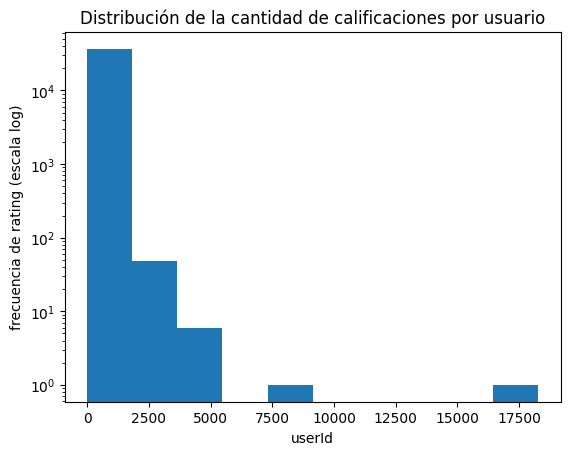

In [80]:
plt.hist(df_user.groupby("userId").size(),log=True)
plt.title("Distribución de la cantidad de calificaciones por usuario")
plt.xlabel("userId")
plt.ylabel("frecuencia de rating (escala log)");

* Los usuarios con ID aproximadamente entre 0 y 5000 tienen la mayor cantidad de calificaciones, mientras que los usuarios con ID alrededor de 8000 y 17500 tienen pocas calificaciones y los usuarios con ID alrededor de 10000 y 15000 tienen muy pocas calificaciones.

* Como un plus se realiza la creación del histograma del número de calificaciones por usuario utilizando todo el campo de "rating" del dataframe original para asegurarnos de que la distribución del número de calificaciones por usuario no se vea afectada por la elección de las puntuaciones de los últimos 7 años. Esto es importante porque si utilizamos solo las calificaciones de los últimos 7 años sin una evaluación, podríamos estar sesgando la distribución hacia las películas más recientes y, por lo tanto, no estaríamos obteniendo una visión completa de la distribución de las calificaciones por usuario en general.

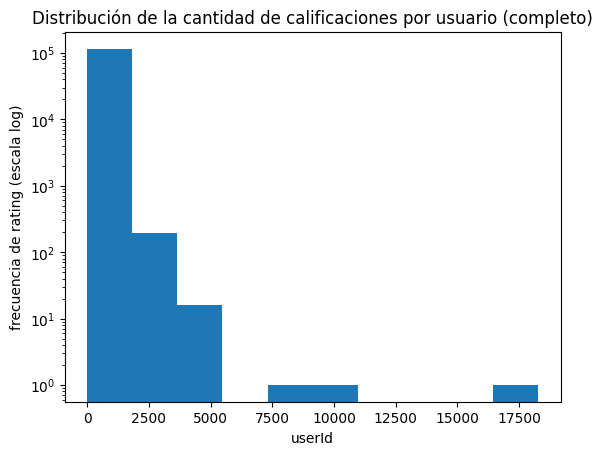

In [81]:
df_prueba=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8]).reset_index(drop=True)
plt.hist(df_prueba.groupby("userId").size(),log=True)
plt.title("Distribución de la cantidad de calificaciones por usuario (completo)")
plt.xlabel("userId")
plt.ylabel("frecuencia de rating (escala log)");

In [82]:
print("Cantidad de usuarios únicos (últimos 7 años): ",df_user.userId.nunique())
print("Cantidad de usuarios únicos (completo): ",df_prueba.userId.nunique())

Cantidad de usuarios únicos (últimos 7 años):  36704
Cantidad de usuarios únicos (completo):  115077


* Conclusión: al comparar la distribución del número de calificaciones por usuario utilizando solo las calificaciones de los últimos 7 años y todo el campo de "rating", hemos observado que ambas distribuciones permanecen prácticamente iguales. Esto indica que no hay una diferencia significativa en la forma en que los usuarios califican las películas en los últimos 7 años en comparación con el comportamiento de los usuarios en general. Por lo tanto, podemos utilizar las calificaciones de los últimos 7 años para nuestras recomendaciones de películas sin temor a sesgar nuestra comprensión de los patrones de calificación de los usuarios en general.

### Countplot de los puntajes (rating)

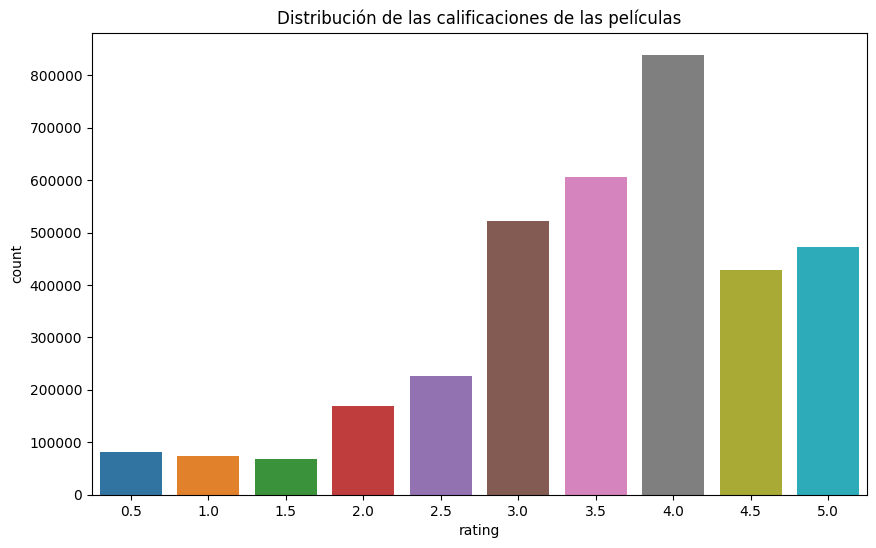

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x=df_user.rating,data=df_user)
plt.title("Distribución de las calificaciones de las películas");

* Se puede observar que el puntaje más frecuente es 4.0, lo cual sugiere que los usuarios tienden a otorgar calificaciones relativamente altas a las películas en general. Por otro lado, el puntaje menos frecuente es 1.5, indicando que los usuarios son menos propensos a calificar las películas con una puntuación muy baja.

### Histograma del número de calificaciones por película

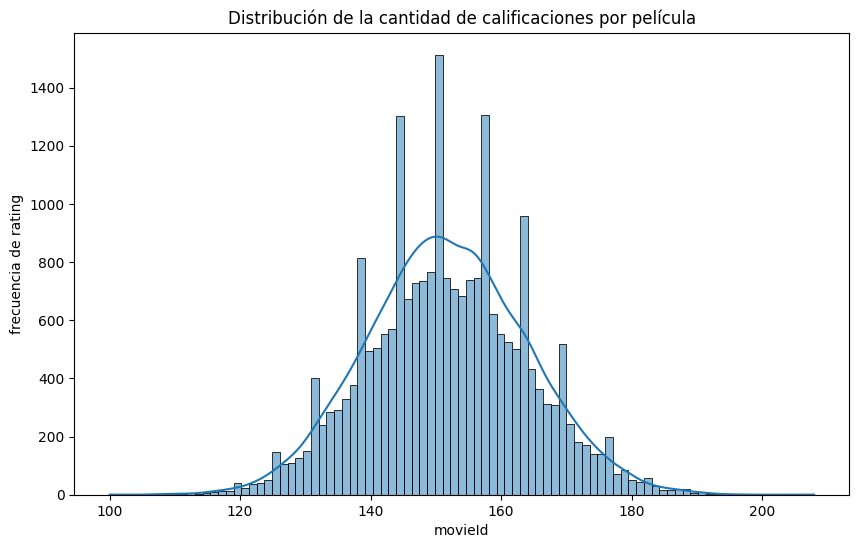

In [86]:
plt.figure(figsize=(10,6))
sns.histplot(df_user.groupby("movieId").size(),kde=True)
plt.title("Distribución de la cantidad de calificaciones por película")
plt.xlabel("movieId")
plt.ylabel("frecuencia de rating");

* El histograma del número de calificaciones por usuario tiene una distribución que se asemeja a una simétrica, con varias modas o picos. El pico principal se encuentra alrededor de 150, lo que sugiere que la película con ID de 150 tiene la mayor cantidad de calificaciones.

### Scatterplot del número de calificaciones de una película vs su puntaje promedio

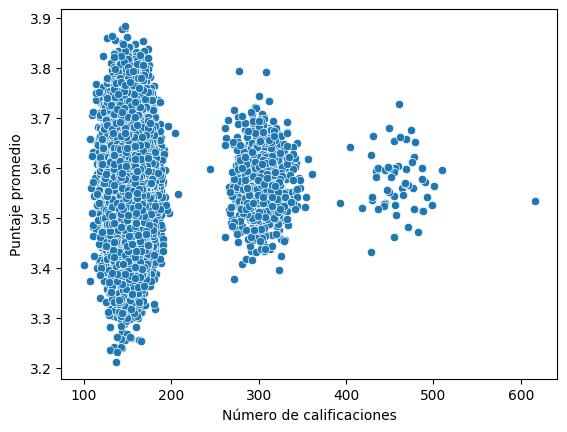

In [98]:
# Uniendo los datos de ambos fata frames
df=pd.merge(df_user,df_movie,left_on="movieId",right_on="id",how="inner")

# Puntaje promedio por película
avg_ratings=df.groupby("title")["rating"].mean()

# Número de calificaciones por película
count_ratings=df.groupby("title")["rating"].count()

# Diagrama de dispersión de número de calificaciones vs. puntaje promedio
sns.scatterplot(x=count_ratings, y=avg_ratings)
plt.xlabel("Número de calificaciones")
plt.ylabel("Puntaje promedio");

* Conclusión: existe una relación entre el número de calificaciones de una película y su puntaje promedio, observándose cuatro grupos principales. El grupo más grande se encuentra entre 100 y 200 calificaciones y tiene una alta densidad de puntos. Esto sugiere que hay muchas películas que han recibido un número moderado de calificaciones y puntajes promedio variados. Por otro lado, el cuarto grupo tiene más de 600 calificaciones y tiene solo un punto. Esto sugiere que hay muy pocas películas que han recibido un gran número de calificaciones y tienen un puntaje promedio de aproximadamente de 3.55.

### Exportación de los data frames para la etapa de Machine Learning

In [99]:
# Se elimina la columna 'timestamp' porque no se utilizará para el sistema de recomendación
# Se exportarían realmente si fuera un sistema de recomendación basado en filtro colaborativo

#df_user.drop(columns=["timestamp"]).to_csv("user_machine.csv",index=False)
#df_movie.to_csv("movie_machine.csv",index=False)